In [ ]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass



Using TensorFlow backend.


In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 20
MAX_VOCAB_SIZE = 3500
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [ ]:
# load in the data
input_texts = []
target_texts = []
for line in open('robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)

all_lines = input_texts + target_texts

In [ ]:
input_texts[0],target_texts[0]

('<sos> Two roads diverged in a yellow wood,',
 'Two roads diverged in a yellow wood, <eos>')

In [ ]:

# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [ ]:
input_sequences[0],target_sequences[0]

([1, 104, 537, 538, 9, 7, 539, 540], [104, 537, 538, 9, 7, 539, 540, 2])

In [ ]:

# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)


Max sequence length: 12


In [ ]:

# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [ ]:


# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [ ]:
input_sequences[:12]

array([[  1, 104, 537, 538,   9,   7, 539, 540,   0,   0,   0,   0],
       [  1,   5, 541,   6,  65,  31, 934, 141,   0,   0,   0,   0],
       [  1,   5,  27,  24, 935, 152,   6, 221,   0,   0,   0,   0],
       [  1,   5, 167,  67,  24,  17, 128,  17,   6,  65,   0,   0],
       [  1,   4,  40,  11, 936,   9,   3, 937,   0,   0,   0,   0],
       [  1,  91, 189,   3, 542,  17,  77,  17, 938,   0,   0,   0],
       [  1,   5, 142, 265,   3, 222, 939,   0,   0,   0,   0,   0],
       [  1, 319,  11,  14, 543,   5, 223, 940,   0,   0,   0,   0],
       [  1, 122,  17,  15,  13,   3, 544,  55,   0,   0,   0,   0],
       [  1,  23, 545,  52, 404, 111,   3, 546,   0,   0,   0,   0],
       [  1,   5, 141,  13, 941, 942, 405,   0,   0,   0,   0,   0],
       [  1,   9, 943,  42, 547,  23, 944, 548,   0,   0,   0,   0]],
      dtype=int32)

In [ ]:
!wget http://www.manythings.org/anki/hin-eng.zip

--2020-07-12 16:15:34--  http://www.manythings.org/anki/hin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126194 (123K) [application/zip]
Saving to: ‘hin-eng.zip’

hin-eng.zip         100%[===================>] 123.24K   334KB/s    in 0.4s    

2020-07-12 16:15:35 (334 KB/s) - ‘hin-eng.zip’ saved [126194/126194]



In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'hin-eng.zip', origin='http://www.manythings.org/anki/hin-eng.zip',
    extract=True)

# path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"


Exception: ignored

In [ ]:
!unzip 'glove.6B.zip.1'

Archive:  glove.6B.zip.1
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!cp glove.6B.200d.txt /content/drive/My\ Drive/

In [ ]:
print("Loading word vectors")
word2vec={}
with open('/content/drive/My Drive/glove.6B.200d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec

print('Found %s word vectors.' % len(word2vec))


Loading word vectors
Found 400000 word vectors.


In [ ]:
print("Fill Pretrained")
num_words = min(MAX_VOCAB_SIZE,len(word2idx)+1) #min(3500,3057)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM)) #3057,200
for word,i in word2idx.items():
  if i<MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
      
embedding_matrix

Fill Pretrained


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.24296001,  0.11026   , -0.028686  , ..., -0.11476   ,
        -0.12265   , -0.10533   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
embedding_matrix.shape

(3057, 200)

In [ ]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words)) #1400,12,3057
print(one_hot_targets.shape)
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

(1436, 12, 3057)


In [ ]:
one_hot_targets[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:


# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)
max_sequence_length

12

In [ ]:
print('Building model...')

input_ = Input(shape = (max_sequence_length,))
init_h = Input(shape=(LATENT_DIM,))
init_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM,return_sequences=True,return_state=True)
x,_,_ = lstm(x,initial_state=[init_h,init_c])
dense = Dense(num_words,activation='softmax')
output =dense(x)
model = Model([input_,init_h,init_c],output)
model.summary()

Building model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 12, 200)      611400      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1148 samples, validate on 288 samples
Epoch 1/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 5.4043 - accuracy: 0.0407 - val_loss: 5.2010 - val_accuracy: 0.0848
Epoch 2/2000
1148/1148 [==============================] - 0s 406us/step - loss: 4.6046 - accuracy: 0.0836 - val_loss: 4.9750 - val_accuracy: 0.0833
Epoch 3/2000
1148/1148 [==============================] - 1s 456us/step - loss: 4.3504 - accuracy: 0.0833 - val_loss: 5.1062 - val_accuracy: 0.0833
Epoch 4/2000
1148/1148 [==============================] - 1s 438us/step - loss: 4.3082 - accuracy: 0.0833 - val_loss: 5.1384 - val_accuracy: 0.0833
Epoch 5/2000
1148/1148 [==============================] - 0s 410us/step - loss: 4.2628 - accuracy: 0.0833 - val_loss: 5.1353 - val_accuracy: 0.0833
Epoch 6/2000
1148/1148 [==============================] - 0s 397us/step - loss: 4.2075 - accuracy: 0.0833 - val_loss: 5.0905 - val_accuracy: 0.0833
Epoch 7/2000
1148/1148 [==============================] - 1s 455us/

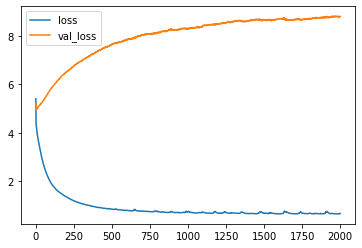

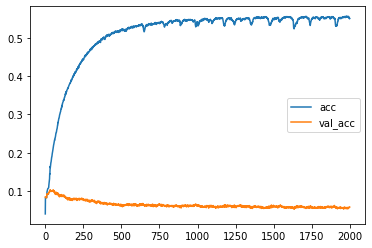

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [ ]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[init_h, init_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, init_h, init_c], [output2, h, c])

# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [ ]:

def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break
    
    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))
    #make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)


In [ ]:

# generate a 4 line poem
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

nor never will be to my way of thinking.
hand for the hole, i can hurt someone as sound as john
to make a leaf, if there and still came at six o'clock
but won't, should be burned at the bedroom
---generate another? [Y/n]---y
how shall we your yourself;
across each other hand of the train and go back
over where the house was to get some place.'
i have we could see it, on the tree.


KeyboardInterrupt: ignored

## Seq2Seq

In [ ]:
# # https://deeplearningcourses.com/c/deep-learning-advanced-nlp
# get the data at: http://www.manythings.org/anki/
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass


Using TensorFlow backend.


In [ ]:
!wget http://www.manythings.org/anki/hin-eng.zip

--2020-07-13 08:24:33--  http://www.manythings.org/anki/hin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126194 (123K) [application/zip]
Saving to: ‘hin-eng.zip.1’

hin-eng.zip.1       100%[===================>] 123.24K   702KB/s    in 0.2s    

2020-07-13 08:24:33 (702 KB/s) - ‘hin-eng.zip.1’ saved [126194/126194]



In [ ]:
!unzip hin-eng.zip
!ls

Archive:  hin-eng.zip
replace hin.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
_about.txt  drive  hin-eng.zip	hin-eng.zip.1  hin.txt	sample_data


In [ ]:


# some config
BATCH_SIZE = 128  # Batch size for training.
EPOCHS = 300  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 20000  # Number of samples to train on.
MAX_NUM_WORDS = 30000
EMBEDDING_DIM = 300


# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

t = 0
for line in open('hin.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue
  
  input_text, translation, *rest = line.rstrip().split('\t')
  # print(input_text," trans:", translation)
  
  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))




num samples: 2774


In [ ]:

# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)


# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)



# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)


# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)


Found 2374 unique input tokens.
Found 3107 unique output tokens.


In [ ]:
max_len_input,max_len_target

(22, 26)

In [ ]:

# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_targets[0])
print("decoder_inputs.shape:", decoder_targets.shape)

encoder_inputs.shape: (2774, 22)
encoder_inputs[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1262]
decoder_inputs[0]: [   2 1473    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (2774, 26)
decoder_inputs[0]: [1473    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (2774, 26)


In [ ]:


# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('/content/drive/My Drive/glove.6B.300d.txt') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector




Loading word vectors...
Found 400000 word vectors.
Filling pre-trained embeddings...


In [ ]:

# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)


# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)
decoder_targets_one_hot.shape

(2774, 26, 3108)

In [ ]:

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

In [ ]:


##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)


# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)
# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [ ]:

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)


def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

# Compile the model and train it
# model.compile(
#   optimizer='rmsprop',
#   loss='categorical_crossentropy',
#   metrics=['accuracy']
# )



r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2219 samples, validate on 555 samples
Epoch 1/300
2219/2219 [==============================] - 3s 1ms/step - loss: 7.0667 - acc: 0.1343 - val_loss: 6.4721 - val_acc: 0.0900
Epoch 2/300
2219/2219 [==============================] - 2s 1ms/step - loss: 5.8108 - acc: 0.1575 - val_loss: 6.5752 - val_acc: 0.0970
Epoch 3/300
2219/2219 [==============================] - 2s 1ms/step - loss: 5.6168 - acc: 0.1581 - val_loss: 6.5268 - val_acc: 0.1014
Epoch 4/300
2219/2219 [==============================] - 2s 1ms/step - loss: 5.4816 - acc: 0.1623 - val_loss: 6.4074 - val_acc: 0.1042
Epoch 5/300
2219/2219 [==============================] - 2s 1ms/step - loss: 5.3261 - acc: 0.1659 - val_loss: 6.2823 - val_acc: 0.1078
Epoch 6/300
2219/2219 [==============================] - 2s 1ms/step - loss: 5.1680 - acc: 0.1732 - val_loss: 6.2404 - val_acc: 0.1134
Epoch 7/300
2219/2219 [==============================] - 2s 1ms/step - loss: 5.0445 - acc: 0.1836 - val_loss: 6.1972 - val_acc: 0.1270
Epoch 8/

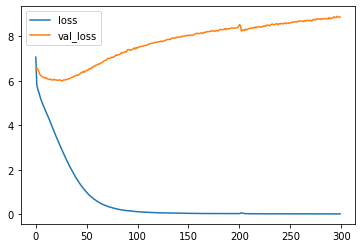

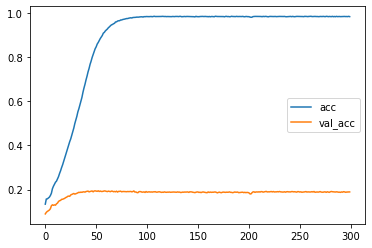

In [ ]:

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# Save model
model.save('s2s.h5')


In [ ]:
r.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [ ]:



##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)


# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}




def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)



while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break



-
Input: If you go to that supermarket, you can buy most things you use in your daily life.
Translation: मुझे अपने दवाई आप को देखने चलें क्या?
Continue? [Y/n]y
-
Input: It's for free.
Translation: यह मुफ़्त का है।
Continue? [Y/n]y
-
Input: This car has enough power to go up the mountain easily.
Translation: उस दरवाज़े से बहुत बड़ा सी गुड़िया से पोंछो।
Continue? [Y/n]y
-
Input: I've never met him, but I recognize him.
Translation: मैं उससे उसके नसीब में नहीं पता था।
Continue? [Y/n]n


# NLP Inshorts

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

seed_urls = ['https://inshorts.com/en/read/technology',
'https://inshorts.com/en/read/business',
'https://inshorts.com/en/read/politics',
'https://inshorts.com/en/read/startup',
'https://inshorts.com/en/read/entertainment',
'https://inshorts.com/en/read/miscellaneous',
'https://inshorts.com/en/read/hatke',
'https://inshorts.com/en/read/science',
'https://inshorts.com/en/read/sports',
'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []

    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    
    return df

news_df = build_dataset(seed_urls)
news_df.head()

,news_headline,news_article,news_category
0,"Google to invest ₹75,000 cr in India to digiti...",Google and Alphabet CEO Sundar Pichai today an...,technology
1,35-yr-old sealed copy of Super Mario Bros sold...,A 35-year-old unopened copy of a Super Mario B...,technology
2,Spoke to Google CEO Pichai on new work culture...,Prime Minister Narendra Modi today interacted ...,technology
3,3 of Ubisoft's highest-ranking executives quit...,French video game firm Ubisoft's Chief Creativ...,technology
4,Google removes 11 apps from Play Store infecte...,Google has removed 11 apps from the Play Store...,technology


In [ ]:
len(news_df)

247

In [ ]:
news_df.news_category.value_counts()

hatke            25
politics         25
startup          25
entertainment    25
business         25
sports           25
miscellaneous    25
world            24
science          24
technology       24
Name: news_category, dtype: int64

In [ ]:
!pip install -U spacy

     |████████████████████████████████| 9.9MB 8.4MB/s 
     |████████████████████████████████| 2.1MB 55.8MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [ ]:
!wget https://github.com/explosion/spacy-models/releases/tag/en_core_web_md-2.0.0

--2020-07-13 10:41:53--  https://github.com/explosion/spacy-models/releases/tag/en_core_web_md-2.0.0
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘en_core_web_md-2.0.0’

en_core_web_md-2.0.     [ <=>                ]  77.89K  --.-KB/s    in 0.01s   

2020-07-13 10:41:53 (6.30 MB/s) - ‘en_core_web_md-2.0.0’ saved [79755]



In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]','', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return ' '.join(new_words)

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return ' '.join(new_words)

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return ' '.join(new_words)

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return ' '.join(new_words)

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return ' '.join(new_words)

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return ' '.join(lemmas)

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    # words = re.sub(r'[\r|\n|\r\n]+','',words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    # f_doc = ''
    # for word in words:
    
    return words


def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems, lemmas


In [ ]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=False,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
  
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = denoise_text(doc)
        # remove accented characters
        if accented_char_removal and text_lower_case and stopword_removal:
            doc = normalize(doc)
            # pass
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_verbs(doc)

        # remove special characters and\or digits    
        # if special_char_removal:
        #     # insert spaces between special characters to isolate them    
        #     special_char_pattern = re.compile(r'([{.(-)!}])')
        #     # doc = special_char_pattern.sub(" \\1 ", doc)
        #     doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # # remove extra whitespace
        # doc = re.sub(' +', ' ', doc)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [ ]:
import re, string, unicodedata
import nltk
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import unicodedata
import spacy
!python -m spacy download en

nlp = spacy.load('en', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def normalize_corpus(corpus, html_stripping=True, contraction_expansion=False,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        # if contraction_expansion:
        #     doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

# pre-process text and store the same
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

# show a sample news article
news_df.iloc[1][['full_text', 'clean_text']]

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


full_text     35-yr-old sealed copy of Super Mario Bros sold...
clean_text    yr old seal copy super mario bro sell lakh set...
Name: 1, dtype: object

In [ ]:
from random import random
from numpy import array
from numpy import cumsum

def get_sequence(n_timesteps):

  # create a sequence of random numbers ranges between [0,1]
  X = array([random() for _ in range(n_timesteps)])

  # calculate threshold value to change class values
  limit = n_timesteps/4.0

  # determine outcome(class) for each item in cumulative sequence
  outcome= [0 if x < limit else 1 for x in cumsum(X)]
  y=array (outcome)

  # reshape input and output data to be suitable for LSTMs
  X = X.reshape(1, n_timesteps, 1)
  y = y.reshape(1, n_timesteps, 1)

  return X, y


T = array([random() for _ in range(10)])
print(T,cumsum(T))

[0.98048916 0.85005061 0.92091675 0.22100305 0.45420316 0.74424717
 0.78206695 0.96033418 0.71002227 0.97041607] [0.98048916 1.83053977 2.75145653 2.97245957 3.42666273 4.1709099
 4.95297685 5.91331102 6.62333329 7.59374936]


In [ ]:

X, y = get_sequence(1000)

print(X)
print(y)

[[[8.59817567e-01]
  [1.82532137e-01]
  [5.25544836e-01]
  [8.86323666e-01]
  [2.33513804e-01]
  [8.04315798e-01]
  [1.99430585e-01]
  [4.95582119e-01]
  [2.87122359e-01]
  [5.83974145e-01]
  [5.64621803e-01]
  [5.34388686e-01]
  [6.45961267e-02]
  [2.71800863e-02]
  [9.31275263e-01]
  [4.90590180e-01]
  [2.62832288e-01]
  [8.33698573e-01]
  [8.32436577e-01]
  [8.78465500e-01]
  [1.65990098e-02]
  [2.44645473e-01]
  [4.41463829e-01]
  [4.99143292e-01]
  [7.51333750e-01]
  [7.04695747e-01]
  [5.79956142e-01]
  [4.28631900e-02]
  [6.53576057e-01]
  [7.92891597e-01]
  [1.11649542e-01]
  [2.07497521e-01]
  [1.13173509e-01]
  [2.07385292e-01]
  [1.41749661e-01]
  [4.96391525e-01]
  [1.45833550e-01]
  [2.12550306e-01]
  [8.55090090e-01]
  [8.43394852e-01]
  [7.89273378e-01]
  [2.31079520e-01]
  [2.80757929e-01]
  [3.68250977e-01]
  [9.24541363e-01]
  [5.21065746e-01]
  [5.60892792e-02]
  [1.27218990e-02]
  [5.92386776e-01]
  [5.90433189e-01]
  [9.49050568e-01]
  [7.24182682e-01]
  [2.0950120

In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, TimeDistributed, LSTM, Dense,Dropout

n_timesteps = 50

model = Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# train LSTM

for epoch in range(1000):
  # generate new random sequence
  X,y = get_sequence(n_timesteps)
  model.fit(X, y, epochs=10, batch_size=64, verbose=2)


Streaming output truncated to the last 5000 lines.
 - 0s - loss: 0.0568 - acc: 0.9600
Epoch 2/10
 - 0s - loss: 0.0598 - acc: 0.9600
Epoch 3/10
 - 0s - loss: 0.0600 - acc: 0.9600
Epoch 4/10
 - 0s - loss: 0.0576 - acc: 0.9600
Epoch 5/10
 - 0s - loss: 0.0532 - acc: 0.9800
Epoch 6/10
 - 0s - loss: 0.0474 - acc: 0.9800
Epoch 7/10
 - 0s - loss: 0.0410 - acc: 0.9800
Epoch 8/10
 - 0s - loss: 0.0346 - acc: 0.9800
Epoch 9/10
 - 0s - loss: 0.0290 - acc: 0.9800
Epoch 10/10
 - 0s - loss: 0.0246 - acc: 1.0000
Epoch 1/10
 - 0s - loss: 0.0510 - acc: 0.9800
Epoch 2/10
 - 0s - loss: 0.0397 - acc: 0.9800
Epoch 3/10
 - 0s - loss: 0.0297 - acc: 0.9800
Epoch 4/10
 - 0s - loss: 0.0222 - acc: 1.0000
Epoch 5/10
 - 0s - loss: 0.0179 - acc: 1.0000
Epoch 6/10
 - 0s - loss: 0.0166 - acc: 1.0000
Epoch 7/10
 - 0s - loss: 0.0176 - acc: 1.0000
Epoch 8/10
 - 0s - loss: 0.0201 - acc: 1.0000
Epoch 9/10
 - 0s - loss: 0.0229 - acc: 0.9800
Epoch 10/10
 - 0s - loss: 0.0255 - acc: 0.9800
Epoch 1/10
 - 0s - loss: 0.1432 - acc:

In [ ]:

for i in range(n_timesteps):

 print('Expected:', y[0, i], 'Predicted', yhat[0, i])

# Modern 
  NLP-CNN

In [ ]:
!unzip /content/drive/My\ Drive/trainingandtestdata.zip

Archive:  /content/drive/My Drive/trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
import pandas as pd

cols = ['sentiment','id','date','query','user','text']
train_df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',header=None,names=cols,engine='python',encoding='latin1')
test_df = pd.read_csv('/content/testdata.manual.2009.06.14.csv',header=None,names=cols,engine='python',encoding='latin1')
train_df.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
train_df.drop(['id','date','query','user'],inplace=True,axis=1)
test_df.drop(['id','date','query','user'],inplace=True,axis=1)

In [ ]:
test_df

,sentiment,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...
...,...,...
493,2,Ask Programming: LaTeX or InDesign?: submitted...
494,0,"On that note, I hate Word. I hate Pages. I hat..."
495,4,Ahhh... back in a *real* text editing environm...
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [ ]:
from bs4 import BeautifulSoup
import numpy as np
import re
import math
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds


def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet,'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+",' ',tweet)
  tweet = re.sub(r"http?://[A-Za-z0-9./]+",' ',tweet)
  tweet = re.sub(r"[^a-zA-Z.!?]",' ',tweet)
  tweet = re.sub(r" +",' ',tweet)
  return tweet
  
clean_train = [clean_tweet(tweet) for tweet in train_df.text]
clean_test = [clean_tweet(tweet) for tweet in test_df.text]


In [ ]:
clean_train

[' Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D',
 'is upset that he can t update his Facebook by texting it... and might cry as a result School today also. Blah!',
 ' I dived many times for the ball. Managed to save The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 ' no it s not behaving at all. i m mad. why am i here? because I can t see you all over there. ',
 ' not the whole crew ',
 'Need a hug ',
 ' hey long time no see! Yes.. Rains a bit only a bit LOL I m fine thanks how s you ?',
 ' K nope they didn t have it ',
 ' que me muera ? ',
 'spring break in plain city... it s snowing ',
 'I just re pierced my ears ',
 ' I couldn t bear to watch it. And I thought the UA loss was embarrassing . . . . .',
 ' It it counts idk why I did either. you never talk to me anymore ',
 ' i would ve been the first but i didn t have a gun. not really though zac snyder s just a doucheclown.',
 ' I wish I got to watch it with you!! I miss you

In [ ]:
data_labels = train_df.sentiment.values
data_labels[data_labels==4]=1
len(data_labels)

1600000

In [ ]:
train_df.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

In [ ]:
data_labels

array([0, 0, 0, ..., 1, 1, 1])

## Tokenize

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=30000, filters='')
tokenizer.fit_on_texts(clean_train)
data_inputs = tokenizer.texts_to_sequences(clean_train)
# target_sequences = tokenizer.texts_to_sequences(target_texts)

Using TensorFlow backend.


In [ ]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    clean_train,target_vocab_size = 30000
)
tokenizer

<SubwordTextEncoder vocab_size=30288>

In [ ]:
len(tokenizer.subwords)

30031

In [ ]:
data_inputs = [tokenizer.encode(s) for s in clean_train]

In [ ]:
# pad
import matplotlib.pyplot as plt

MAX_LEN = max([len(s) for s in data_inputs])
lens = [len(s) for s in data_inputs]

val_counts = pd.DataFrame({'lens':lens})

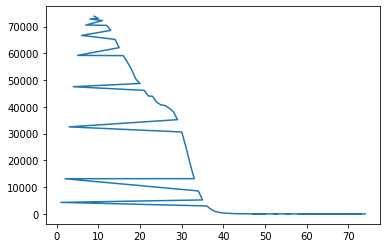

In [ ]:
val_counts['lens'].value_counts().plot(kind='line')

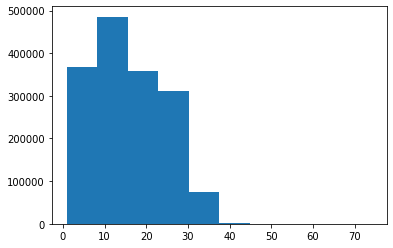

In [ ]:
plt.hist(lens, bins = 10)
plt.show()

In [ ]:
MAX_LEN

74

In [ ]:
data_inputs_pad = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,value=0,maxlen=MAX_LEN-20,padding='post')

In [ ]:
data_inputs_pad

array([[  518,    16,    12, ...,     0,     0,     0],
       [    9,   860,    16, ...,     0,     0,     0],
       [    1,   289,   413, ...,     0,     0,     0],
       ...,
       [   35,     7,   195, ...,     0,     0,     0],
       [  114,   304,   301, ...,     0,     0,     0],
       [  114, 23433,     0, ...,     0,     0,     0]], dtype=int32)

In [ ]:
np.array(data_inputs_pad).shape

(1600000, 54)

In [ ]:
test_idx = np.random.randint(8,800000,8000)
test_idx = np.concatenate((test_idx,test_idx+800000))

In [ ]:
test_inputs = data_inputs_pad[test_idx]
test_labels = data_labels[test_idx]
train_inputs = np.delete(data_inputs_pad,test_idx,axis=0)
train_labels = np.delete(data_labels,test_idx)

In [ ]:
print("Loading word vectors")
word2vec={}
with open('/content/drive/My Drive/glove.6B.200d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec

print('Found %s word vectors.' % len(word2vec))


Loading word vectors
Found 400000 word vectors.


In [ ]:
word2idx = tokenizer.word_index
word2idx

{'i': 1,
 'to': 2,
 'the': 3,
 'a': 4,
 'my': 5,
 'and': 6,
 'you': 7,
 'it': 8,
 'is': 9,
 'for': 10,
 'in': 11,
 's': 12,
 'of': 13,
 't': 14,
 'on': 15,
 'that': 16,
 'so': 17,
 'have': 18,
 'm': 19,
 'me': 20,
 'but': 21,
 'just': 22,
 'with': 23,
 'at': 24,
 'be': 25,
 'not': 26,
 'was': 27,
 'can': 28,
 'this': 29,
 'get': 30,
 'good': 31,
 'up': 32,
 'all': 33,
 'like': 34,
 'are': 35,
 'out': 36,
 'no': 37,
 'now': 38,
 'day': 39,
 'go': 40,
 'your': 41,
 'going': 42,
 'we': 43,
 'love': 44,
 'got': 45,
 'do': 46,
 'what': 47,
 'from': 48,
 'am': 49,
 'work': 50,
 'u': 51,
 'back': 52,
 'will': 53,
 'don': 54,
 'about': 55,
 'im': 56,
 'too': 57,
 'one': 58,
 'had': 59,
 'really': 60,
 'time': 61,
 'know': 62,
 'some': 63,
 'see': 64,
 '.': 65,
 'today': 66,
 'if': 67,
 'its': 68,
 'lol': 69,
 'how': 70,
 'they': 71,
 'still': 72,
 'new': 73,
 'want': 74,
 'll': 75,
 'think': 76,
 'when': 77,
 'as': 78,
 'he': 79,
 'there': 80,
 'oh': 81,
 'miss': 82,
 're': 83,
 'more': 84,
 '

In [ ]:
print("Fill Pretrained")
num_words = min(30000,len(word2idx)+1)
print("Num_words=",num_words)
embedding_matrix = np.zeros((num_words,200)) #3057,200
for word,i in word2idx.items():
  if i<num_words:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
      
embedding_matrix

Fill Pretrained
Num_words= 30000


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26804999,  0.36032   , -0.33199999, ...,  0.17769   ,
         0.22362   ,  0.014241  ],
       [ 0.57345998,  0.54170001, -0.23477   , ...,  0.54417998,
        -0.23069   ,  0.34946999],
       ...,
       [-0.79562002, -0.058982  , -0.64007002, ..., -0.40812001,
        -0.038176  , -0.39567   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17348   , -0.46671   , -0.68326002, ...,  0.13434   ,
        -0.69617999,  0.11309   ]])

In [ ]:
class DCNN(tf.keras.Model):
  def __init__(self,vocab_size,emb_dim=200,nb_filters=50, nb_classes=2,
               ffn_units=2,dropout=0.2,training=False,name='dcnn'):
    super(DCNN,self).__init__()
    self.embedding = layers.Embedding(vocab_size,emb_dim,weights=[embedding_matrix])
    self.bigram = layers.Conv1D(filters=nb_filters,kernel_size=2,
                                padding='valid',activation='relu')
    self.pool_1 = layers.GlobalMaxPooling1D()
    self.trigram = layers.Conv1D(filters=nb_filters,kernel_size=3,
                                padding='valid',activation='relu')
    self.pool_2 = layers.GlobalMaxPooling1D()
    self.fourgram = layers.Conv1D(filters=nb_filters,kernel_size=4,
                                padding='valid',activation='relu')
    self.pool_3 = layers.GlobalMaxPooling1D()

    self.dense_1 = layers.Dense(units=ffn_units,activation='relu')
    self.dropout = layers.Dropout(dropout)

    self.out_put = layers.Dense(1,activation='sigmoid')
  
  def call(self,inputs,training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool_1(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool_2(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool_3(x_3)

    merged = tf.concat([x_1,x_2,x_3],axis=1) # batch * 3*nb_filters
    merged = self.dense_1(merged)
    merged=self.dropout(merged,training)
    out_put = self.out_put(merged)
    return out_put

In [ ]:
vocab_size = num_words
EMB_DIM=200
NB_FILTERS=100
FFN_UNITS=512
NB_CLASSES=2 
DROUPOUT=0.5
BATCH_SIZE=32
EPOCHS=7


In [ ]:
dcnn = DCNN(vocab_size,EMB_DIM,NB_FILTERS,NB_CLASSES,FFN_UNITS,DROUPOUT)

if NB_CLASSES==2:
  dcnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
else:
  dcnn.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_Categorical_accuracy'])

In [ ]:
ckpt_path = './drive/My Drive/'
ckpt = tf.train.Checkpoint(dcnn=dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt,ckpt_path,max_to_keep=1)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("CKPT Saved")

In [ ]:
dcnn.fit(train_inputs,train_labels,batch_size=BATCH_SIZE,
         epochs=EPOCHS)
ckpt_manager.save()

Epoch 1/7
19984/49503 [===========>..................] - ETA: 32:42 - loss: 0.4409 - accuracy: 0.7954

In [ ]:
# evaluation

# Transformer

In [ ]:
5. Transformer - Application (Eng - Fr translator):
        Google Colab file: https://colab.research.google.com/drive/1i4a26jVRVsAIfAGCe5pnl4l51B6GvjWs
        Data link: http://www.statmt.org/europarl/ for all pairs
                          http://www.statmt.org/europarl/v7/fr-en.tgz for the En-Fr in the course
                          https://drive.google.com/file/d/14wOcOrg8YJWXze6RvMy1cisDJKaFukff/view?usp=sharing for nonbreaking_prefix.en
                          https://drive.google.com/file/d/1z4iM2n4t1guAxHZ0URfmzrjz3zknW64L/view?usp=sharing for non

In [ ]:
!wget https://www.statmt.org/europarl/v7/fr-en.tgz 

--2020-07-17 16:52:48--  https://www.statmt.org/europarl/v7/fr-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202718517 (193M) [application/x-gzip]
Saving to: ‘fr-en.tgz’

fr-en.tgz           100%[===================>] 193.33M  4.14MB/s    in 47s     

2020-07-17 16:53:36 (4.14 MB/s) - ‘fr-en.tgz’ saved [202718517/202718517]



In [ ]:
!tar -xvf /content/fr-en.tgz

europarl-v7.fr-en.en
europarl-v7.fr-en.fr


In [ ]:
import numpy as np
import math
import re
import time
import tensorflow as tf
from tensorflow.keras import layers
import nltk
import tensorflow_datasets as tfds

In [ ]:
with open('/content/europarl-v7.fr-en.en', 'r', encoding = 'utf-8') as f:
  corpus_en = f.read()
with open('/content/europarl-v7.fr-en.fr', 'r', encoding = 'utf-8') as f:
  corpus_fr = f.read()

non_breaking_prefix_en = """a,b,c,d,e,f,g,h,i,j,k,l,m,n,o
,p,q,r,s,t,uv,w,x,,y,z,messrs,mlle,mme,mr,mrs,ms
,ph,prof,sr,st,a.m,p.m,vs,i.e,e.g""".split(',')

non_breaking_prefix_fr = """
a,b,c,d,e,f,g,h,i,j,k,l,m,n,o
,p,q,r,s,t,uv,w,x,,y,z,
mme,
mlle,
c.-à-d,
cf,
chap,
e.g,
al,
etc,
ex,
fig,
suiv,
sup,
suppl,
tél,
vol,
vs""".split(',')

In [ ]:
non_breaking_prefix_en = [' ' + pref + '.' for pref in non_breaking_prefix_en]
non_breaking_prefix_fr = [' ' + pref + '.' for pref in non_breaking_prefix_fr]
non_breaking_prefix_en

[' a.',
 ' b.',
 ' c.',
 ' d.',
 ' e.',
 ' f.',
 ' g.',
 ' h.',
 ' i.',
 ' j.',
 ' k.',
 ' l.',
 ' m.',
 ' n.',
 ' o\n.',
 ' p.',
 ' q.',
 ' r.',
 ' s.',
 ' t.',
 ' uv.',
 ' w.',
 ' x.',
 ' .',
 ' y.',
 ' z.',
 ' messrs.',
 ' mlle.',
 ' mme.',
 ' mr.',
 ' mrs.',
 ' ms\n.',
 ' ph.',
 ' prof.',
 ' sr.',
 ' st.',
 ' a.m.',
 ' p.m.',
 ' vs.',
 ' i.e.',
 ' e.g.']

In [ ]:
import re
# Add $$$ after non ending sentence points
for prefix in non_breaking_prefix_en:
    corpus_en = corpus_en.replace(prefix, prefix + '$$$')
corpus_en = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus_en)
# Remove $$$ markers
corpus_en = re.sub(r".\$\$\$", '', corpus_en)
# Clear multiple spaces
corpus_en = re.sub(r"  +", " ", corpus_en)
corpus_en = corpus_en.split('\n')

for prefix in non_breaking_prefix_fr:
    corpus_fr = corpus_fr.replace(prefix, prefix + '$$$')
corpus_fr = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus_fr)
corpus_fr = re.sub(r".\$\$\$", '', corpus_fr)
corpus_fr = re.sub(r"  +", " ", corpus_fr)
corpus_fr = corpus_fr.split('\n')

In [ ]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    corpus_en, target_vocab_size=2**15)
tokenizer_fr = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    corpus_fr, target_vocab_size=2**15)

In [ ]:
VOCAB_SIZE_EN = tokenizer_en.vocab_size + 2 # = 8190
VOCAB_SIZE_FR = tokenizer_fr.vocab_size + 2 # = 8171

In [ ]:
inputs = [[VOCAB_SIZE_EN-2] + tokenizer_en.encode(sentence) + [VOCAB_SIZE_EN-1]
          for sentence in corpus_en]
outputs = [[VOCAB_SIZE_FR-2] + tokenizer_fr.encode(sentence) + [VOCAB_SIZE_FR-1]
           for sentence in corpus_fr]

In [ ]:
inputs

[[32503, 11526, 3, 1, 2462, 32504],
 [32503,
  11,
  3288,
  3814,
  1,
  1971,
  3,
  1,
  22,
  63,
  8087,
  12,
  5715,
  2689,
  1200,
  1535,
  2,
  5,
  11,
  32,
  54,
  381,
  365,
  4,
  292,
  52,
  7,
  1445,
  74,
  293,
  6,
  1,
  194,
  8,
  52,
  4972,
  7,
  10578,
  27949,
  678,
  1727,
  32293,
  32504],
 [32503,
  16303,
  2,
  20,
  52,
  26,
  17,
  5598,
  2,
  1,
  27965,
  562,
  171,
  9568,
  24488,
  84,
  1705,
  4,
  14250,
  2,
  159,
  1,
  94,
  6,
  7,
  197,
  3,
  95,
  2694,
  7,
  1681,
  3,
  906,
  3031,
  8,
  1567,
  108,
  27219,
  32293,
  32504],
 [32503,
  503,
  17,
  2392,
  7,
  160,
  12,
  15,
  409,
  6,
  1,
  420,
  3,
  1,
  252,
  298,
  2446,
  2,
  330,
  15,
  839,
  32292,
  2462,
  32293,
  32504],
 [32503,
  59,
  1,
  4781,
  2,
  11,
  34,
  54,
  4,
  3768,
  7,
  4902,
  84,
  28,
  7700,
  2,
  20,
  7,
  197,
  3,
  297,
  17,
  7350,
  2,
  12,
  244,
  3,
  39,
  1,
  1082,
  533,
  2,
  217,
  93,
  3,
  1,
  3107

In [ ]:
outputs

[[32821, 14236, 1, 3, 3630, 32822],
 [32821,
  32,
  2767,
  1947,
  3,
  1649,
  13,
  61,
  92,
  19,
  378,
  48,
  5917,
  5,
  5762,
  2570,
  1223,
  657,
  4,
  29,
  51,
  14825,
  32597,
  84,
  279,
  17296,
  10,
  10096,
  9,
  51,
  297,
  1147,
  1,
  1120,
  14876,
  32611,
  32822],
 [32821,
  398,
  51,
  297,
  521,
  5,
  6013,
  2,
  5,
  4671,
  165,
  5742,
  18752,
  1,
  32673,
  32604,
  952,
  921,
  353,
  26,
  32680,
  32604,
  12,
  23,
  3735,
  40,
  83,
  2563,
  2,
  7,
  157,
  32665,
  32604,
  15,
  505,
  190,
  1,
  90,
  53,
  37,
  48,
  842,
  1,
  2194,
  3166,
  19,
  37,
  561,
  48,
  12979,
  32680,
  32611,
  32822],
 [32821,
  540,
  297,
  3674,
  15,
  168,
  6,
  20,
  322,
  16,
  7,
  3052,
  1626,
  2,
  22,
  227,
  1,
  33,
  504,
  1,
  3630,
  32611,
  32822],
 [32821,
  83,
  9288,
  2,
  29,
  14651,
  2,
  55,
  15,
  505,
  190,
  1,
  508,
  111,
  32673,
  32604,
  37,
  5322,
  2,
  9,
  17,
  18105,
  722,
  14,
  3968,

In [ ]:
MAX_LENGTH = 20
idx_to_remove = [count for count, sent in enumerate(inputs)
                 if len(sent) > MAX_LENGTH]
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]
idx_to_remove = [count for count, sent in enumerate(outputs)
                 if len(sent) > MAX_LENGTH]
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]

In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=MAX_LENGTH)
outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=MAX_LENGTH)

In [ ]:
inputs.shape

(446970, 20)

In [ ]:
inputs[50]

array([32503,    11,    32,    54,     4,   804,    64,   590,   701,
       32293, 32504,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

In [ ]:
with open('input_transformer.txt','w') as f:
  for i in inputs:
    f.write('%s\n'%i)

with open('output_transformer.txt','w') as f:
  for i in outputs:
    f.write('%s\n'%i)

In [ ]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model):
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles

    def call(self, inputs):
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        pos_encoding = angles[np.newaxis, ...]
        return inputs + tf.cast(pos_encoding, tf.float32)

$Attention(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V $

In [ ]:
def scaled_dot_product_attention(queries, keys, values, mask):
  product = tf.matmul(queries, keys, transpose_b=True)
  #dk is the dimention of key, we use it to scale our product
  keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
  # we use tf.cast because we want to output as float so we can take sqrt and divide
  scaled_product = product / tf.math.sqrt(keys_dim)
  
  if mask is not None:
      scaled_product += (mask * -1e9)

  attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
  return attention
  

In [ ]:
class MultiHeadAttention(layer.Layer):
  
  def __init__(self,nb_proj):
    super(MultiHeadAttention,self).__init__()
    self.nb_proj = nb_proj

  def build(self,input_shape):
    self.d_model = input_shape[-1]
    assert self.d_model % self.nb_proj == 0
    self.d_proj = self.d_model // self.nb_proj

    self.query_lin=layer.Dense(self.d_model)
    self.key_lin=layer.Dense(self.d_model)
    self.val_lin=layer.Dense(self.d_model)

    self.final_lin = layer.Dense(self.d_model)


  def split_proj(self,inputs,bs): #inputs(bs,seq_len,d_model)
    # split sequence into n_proj no of equal parts for batchsize
    shape = (bs,-1,self.nb_proj,self.d_proj) #batch,seqlen,nb_proj,d_proj
    splited_inputs = tf.reshape(inputs,shape = shape)

    return tf.transpose(splited_inputs,perm=[0,2,1,3])

  def call(self,query,key,values,mask):
    bs = tf.shape(query)[0]
    query = self.query_lin(query)
    key = self.key_lin(key)
    values = self.val_lin(values)

    #split the inputs in nb_proj
    query = self.split_proj(query,batchsize)
    key = self.split_proj(key,batchsize)
    values = self.split_proj(values,batchsize)

    attention = scaled_dot_prouct_attention(query,key,values,mask)

    attention = tf.transpose(attention,perm=[0,2,1,3])
    concat_att = tf.reshape(attention,shape = (bs,-1,self.d_model))

    outputs = self.final_lin(concat_att)
    return outputs

(20, 1)

In [ ]:
class EncoderLayer(layer.Layer):

  def __init__(self,ffn_unit,nb_proj,dropout):
    super(EncoderLayer,self).__init__()
    self.nb_proj = nb_proj
    self.dropout = dropout
    self.ffn_unit = ffn_unit

  def build(input_shape):
    self.d_model = input_shape[-1]

    self.multi_h_att = MultiHeadAttention(self.nb_proj)
    self.dropout_1 = layer.Dropout(self.dropout)
    self.norm_1 = layer.LayerNormalization(1e-6)
    self.dense_1 = layers.Dense(units=self.FFN_units, activation="relu")
    
    self.dense_2 = layers.Dense(units=self.d_model)
    self.dropout_2 = layers.Dropout(rate=self.dropout)
    self.norm_2 = layers.LayerNormalization(epsilon=1e-6)

  def call(self,inputs,mask,training):
    attention = self.multi_h_att(inputs,inputs,inputs,mask)
    attention = self.dropout_1(attention,training = training)
    attention = self.norm_1(attention+inputs)

    outputs = self.dense_1(attention)
    outputs = self.dense_2(outpus)
    outputs = self.dropout_2(outputs)
    outputs = self.norm_1(outputs+attention)

    return outputs

In [ ]:
class Encoder(layer.Layer):
  def __init__(self,nb_layers,FFN_units,nb_proj,dropout_rate,
                 vocab_size,d_model,name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.nb_layers = nb_layers
        self.d_model = d_model
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.enc_layers = [EncoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for _ in range(nb_layers)]
    
    def call(self, inputs, mask, training):
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        
        for i in range(self.nb_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

In [ ]:
data = """This file contains the actual data for your assignment - good luck!


Why should you learn to write programs?

Writing programs (or programming) is a very creative 
1394 and rewarding activity.  You can write programs for 
many reasons, ranging from making your living to solving
a difficult data analysis problem to having fun to helping
7541 someone else solve a problem.  This book assumes that 6726
everyone needs to know how to program, and that once 
you know how to program you will figure out what you want 
to do with your newfound skills.  

We are surrounded in our daily lives with computers ranging 
from laptops to cell phones.  We can think of these computers
as our personal assistants who can take care of many things
on our behalf.  The hardware in our current-day computers 
is essentially built to continuously ask us the question, 
What would you like me to do next?

Programmers add an operating system and a set of applications
to the hardware and we end up with a Personal Digital
Assistant that is quite helpful and capable of helping
us do many different things.

Our computers are fast and have vast amounts of memory and 
could be very helpful to us if we only knew the language to
speak to explain to the computer what we would like it to 
do next.  If we knew this language, we could tell the 
computer to do tasks on our behalf that were repetitive.  
Interestingly, the kinds of things computers can do best
are often the kinds of things that we humans find boring
and mind-numbing.

For example, look at the first three paragraphs of this
chapter and tell me the most commonly used word and how
many times the word is used.  While you were able to read
and understand the words in a few seconds, counting them
is almost painful because it is not the kind of problem 
that human minds are designed to solve.  For a computer
the opposite is true, reading and understanding text 
4556 from a piece of paper is hard for a computer to do 9585
but counting the words and telling you how many times
the most used word was used is very easy for the
computer:

Our personal information analysis assistant quickly 
told 9953 us 3413 that 9000 the word to was used sixteen times in the
 first three paragraphs of this chapter.

This very fact that computers are good at things 
that humans are not is why you need to become
skilled 8951 at 663 talking 7590 computer language.  Once you learn
 this new language, you can delegate mundane tasks
to your partner (the computer), leaving more time 
for you to do the 
things that you are uniquely suited for.  You bring 
creativity, intuition, and inventiveness to this
partnership.  

5035 Creativity and motivation

While this book is not intended for professional programmers, professional
programming can be a very rewarding job both financially and personally.
Building useful, elegant, and clever programs for others to use is a very
creative activity.  Your computer or Personal Digital Assistant (PDA) 
usually contains many different programs from many different groups of 
programmers, each competing for your attention and interest.  They try 
their best to meet your needs and give you a great user experience in the
process.   In some situations, when you choose a piece of software, the 
programmers are directly compensated because of your choice.

If we think of programs as the creative output of groups of programmers,
perhaps the following figure is a more sensible version of our PDA:

For now, our primary motivation is not to make money or please end users, but
instead for us to be more productive in handling the data and 
information that we will encounter in our lives.
When you first start, you will be both the programmer and the end user of
your programs.  As you gain skill as a programmer and
programming feels more creative to you, your thoughts may turn
toward developing programs for others.

Computer hardware architecture

Before we start learning the language we 
speak to give instructions to computers to 
develop software, we need to learn a small amount about 
how computers are built.  
6479 2310 9692
Central Processing Unit (or CPU) is 
the part of the computer that is built to be obsessed 
with what is next?  If your computer is rated
at three Gigahertz, it means that the CPU will ask What next?
three billion times per second.  You are going to have to 
learn how to talk fast to keep up with the CPU.

Main Memory is used to store information
that the CPU needs in a hurry.  The main memory is nearly as 
fast as the CPU.  But the information stored in the main
memory vanishes when the computer is turned off.

Secondary Memory is also used to store
information, but it is much slower than the main memory.
The advantage of the secondary memory is that it can
store information even when there is no power to the
computer.  Examples of secondary memory are disk drives
or flash memory (typically found in USB sticks and portable
music players).

Input and Output Devices are simply our
screen, keyboard, mouse, microphone, speaker, touchpad, etc.  
They 7149 are 2033 all 5315 of the ways we interact with the computer.
 393 
These days, most computers also have a
Network Connection to retrieve information over a network.
We can think of the network as a very slow place to store and
retrieve data that might not always be up.  So in a sense,
the network is a slower and at times unreliable form of
Secondary Memory.

While most of the detail of how these components work is best left 
to computer builders, it helps to have some terminology
so we can talk about these different parts as we write our programs.

As a programmer, your job is to use and orchestrate 
each of these resources to solve the problem that you need to solve
and analyze the data you get from the solution.  As a programmer you will 
mostly be talking to the CPU and telling it what to 
do next.  Sometimes you will tell the CPU to use the main memory,
secondary memory, network, or the input/output devices.

You need to be the person who answers the CPU's What next? 
question.  But it would be very uncomfortable to shrink you 
down 6647 to 7474 five 9707 mm  tall and insert you into the computer just so you 
 could issue a command three billion times per second.  So instead,
you must write down your instructions in advance.
We call these stored instructions a program and the act 
of writing these instructions down and getting the instructions to 
be correct programming.

Understanding programming

In the rest of this book, we will try to turn you into a person
who is skilled in the art of programming.  In the end you will be a 
programmer --- perhaps not a professional programmer, but 
at least you will have the skills to look at a data/information
analysis problem and develop a program to solve the problem.

problem solving

In a sense, you need two skills to be a programmer:

First, you need to know the programming language (Python) -
you need to know the vocabulary and the grammar.  You need to be able 
to spell the words in this new language properly and know how to construct 
well-formed sentences in this new language.

Second, you need to tell a story.  In writing a story,
you combine words and sentences to convey an idea to the reader. 
There is a skill and art in constructing the story, and skill in
story writing is improved by doing some writing and getting some
feedback.  In programming, our program is the story and the 
problem you are trying to solve is the idea.

7914 1962 6788

Once you learn one programming language such as Python, you will 
find it much easier to learn a second programming language such
as JavaScript or C++.  The new programming language has very different 
vocabulary and grammar but the problem-solving skills 
will be the same across all programming languages.

You will learn the vocabulary and sentences of Python pretty quickly.
It will take longer for you to be able to write a coherent program
to solve a brand-new problem.  We teach programming much like we teach
writing.  We start reading and explaining programs, then we write 
simple programs, and then we write increasingly complex programs over time.
At 5870 some 2495 point 4243 you get your muse and see the patterns on your own
 and can see more naturally how to take a problem and 
write a program that solves that problem.  And once you get 
to that point, programming becomes a very pleasant and creative process.  

We start with the vocabulary and structure of Python programs.  Be patient
as the simple examples remind you of when you started reading for the first
time. 
4690  6874
Words and sentences

Unlike human languages, the Python vocabulary is actually pretty small.
We call this vocabulary the reserved words.  These are words that
have very special meaning to Python.  When Python sees these words in 
a Python program, they have one and only one meaning to Python.  Later
as you write programs you will make up your own words that have meaning to 
you called variables.   You will have great latitude in choosing
your names for your variables, but you cannot use any of Python's 
reserved words as a name for a variable.

When we train a dog, we use special words like
sit, stay, and fetch.  When you talk to a dog and
don't use any of the reserved words, they just look at you with a 
quizzical look on their face until you say a reserved word.  
4704 For example, if you say, 
I wish more people would walk to improve their overall health, 
what most dogs likely hear is,
blah blah blah walk blah blah blah blah.
That is because walk is a reserved word in dog language.  

4405 The reserved words in the language where humans talk to 5882
Python include the following:

and       del       from      not       while    
as        elif      global    or        with     
assert    else      if        pass      yield    
break     except    import    print              
class     exec      in        raise              
continue  finally   is        return             
def       for       lambda    try

That is it, and unlike a dog, Python is already completely trained.
When you say try, Python will try every time you say it without
fail.

We will learn these reserved words and how they are used in good time,
but for now we will focus on the Python equivalent of speak (in 
human-to-dog language).  The nice thing about telling Python to speak
is that we can even tell it what to say by giving it a message in quotes:

And we have even written our first syntactically correct Python sentence.
Our sentence starts with the reserved word print followed
by a string of text of our choosing enclosed in single quotes.

Conversing with Python

Now that we have a word and a simple sentence that we know in Python,
we need to know how to start a conversation with Python to test 
our new language skills.
8798  6790
Before you can converse with Python, you must first install the Python
1617 software on your computer and learn how to start Python on your 4690
computer.  That is too much detail for this chapter so I suggest
that 4586 you 4397 consult 2617 www.py4e.com where I have detailed
 instructions and screencasts of setting up and starting Python 
on Macintosh and Windows systems.  At some point, you will be in 
a terminal or command window and you will type python and 
the Python interpreter will start executing in interactive mode
and appear somewhat as follows:
interactive mode

The >>> prompt is the Python interpreter's way of asking you, What
do you want me to do next?  Python is ready to have a conversation with
you.  All you have to know is how to speak the Python language.

Let's say for example that you did not know even the simplest Python language
words or sentences. You might want to use the standard line that astronauts 
use when they land on a faraway planet and try to speak with the inhabitants
of the planet:

This 9451 is 452 not 2869 going so well.  Unless you think of something quickly,
 8793 the inhabitants of the planet are likely to stab you with their spears, 8911
put you on a spit, roast you over a fire, and eat you for dinner.

At 3141 this 1849 point, 4299 you should also realize that while Python 
 is amazingly complex and powerful and very picky about 
the syntax you use to communicate with it, Python is 
not intelligent.  You are really just having a conversation
with yourself, but using proper syntax.

In a sense, when you use a program written by someone else
the conversation is between you and those other
programmers with Python acting as an intermediary.  Python
is a way for the creators of programs to express how the 
conversation is supposed to proceed.  And
in just a few more chapters, you will be one of those
programmers using Python to talk to the users of your program.

Before we leave our first conversation with the Python 
interpreter, you should probably know the proper way
4108 to say good-bye when interacting with the inhabitants 6982
of Planet Python:
7863 
You will notice that the error is different for the first two
incorrect attempts.   The second error is different because 
if is a reserved word and Python saw the reserved word
and thought we were trying to say something but got the syntax
of the sentence wrong.

Terminology: 2675 interpreter 3148 and 9315 compiler
 
Python is a high-level language intended to be relatively
straightforward for humans to read and write and for computers
to read and process.  Other high-level languages include Java, C++,
PHP, Ruby, Basic, Perl, JavaScript, and many more.  The actual hardware
inside the Central Processing Unit (CPU) does not understand any
of these high-level languages.
8257  4055
The CPU understands a language we call machine language.  Machine
language is very simple and frankly very tiresome to write because it 
is represented all in zeros and ones.

Machine language seems quite simple on the surface, given that there 
are only zeros and ones, but its syntax is even more complex
4023 and far more intricate than Python.  So very few programmers ever write
machine language.  Instead we build various translators to allow
programmers to write in high-level languages like Python or JavaScript
and these translators convert the programs to machine language for actual
execution by the CPU.
2365  6700
Since machine language is tied to the computer hardware, machine language
is not portable across different types of hardware.  Programs written in 
high-level languages can be moved between different computers by using a 
different interpreter on the new machine or recompiling the code to create
a machine language version of the program for the new machine.

These programming language translators fall into two general categories:
(one) interpreters and (two) compilers.

An interpreter reads the source code of the program as written by the
programmer, parses the source code, and interprets the instructions on the fly.
Python is an interpreter and when we are running Python interactively, 
we can type a line of Python (a sentence) and Python processes it immediately
and is ready for us to type another line of Python.   

816 Some of the lines of Python tell Python that you want it to remember some 
value for later.   We need to pick a name for that value to be remembered and
6721 we can use that symbolic name to retrieve the value later.  We use the 
term variable to refer to the labels we use to refer to this stored data.
5740 9862 6680
In this example, we ask Python to remember the value six and use the label x
so we can retrieve the value later.   We verify that Python has actually remembered
the value using x and multiply
144 it by seven and put the newly computed value in y.  Then we ask Python to print out 5514
the value currently in y.

Even though we are typing these commands into Python one line at a time, Python
is treating them as an ordered sequence of statements with later statements able
to retrieve data created in earlier statements.   We are writing our first 
simple paragraph with four sentences in a logical and meaningful order.

It is the nature of an interpreter to be able to have an interactive conversation
as shown above.  A compiler needs to be handed the entire program in a file, and then 
it runs a process to translate the high-level source code into machine language
and then the compiler puts the resulting machine language into a file for later
execution.

104 If you have a Windows system, often these executable machine language programs have a 4669
suffix of .exe or .dll which stand for executable and dynamic link
library respectively.  In Linux and Macintosh, there is no suffix that uniquely marks
a file as executable.

If you were to open an executable file in a text editor, it would look 
completely crazy and be unreadable:

It is not easy to read or write machine language, so it is nice that we have
compilers that allow us to write in high-level
languages like Python or C.

Now at this point in our discussion of compilers and interpreters, you should 
be wondering a bit about the Python interpreter itself.  What language is 
it written in?  Is it written in a compiled language?  When we type
python, what exactly is happening?

The Python interpreter is written in a high-level language called C.  
6841 You can look at the actual source code for the Python interpreter by
going to www.python.org and working your way to their source code.
So Python is a program itself and it is compiled into machine code.
When you installed Python on your computer (or the vendor installed it),
you copied a machine-code copy of the translated Python program onto your
system.   In Windows, the executable machine code for Python itself is likely
in a file.

That is more than you really need to know to be a Python programmer, but
sometimes it pays to answer those little nagging questions right at 
the beginning.

Writing a program

Typing 3721 commands 6013 into 246 the Python interpreter is a great way to experiment 
 with Python's features, but it is not recommended for solving more complex problems.

When we want to write a program, 
we use a text editor to write the Python instructions into a file,
which is called a script.  By
convention, Python scripts have names that end with .py.

script

To execute the script, you have to tell the Python interpreter 
the name of the file.  In a Unix or Windows command window, 
you would type python hello.py as follows:

We call the Python interpreter and tell it to read its source code from
the file hello.py instead of prompting us for lines of Python code
interactively.
4624 
You will notice that there was no need to have quit() at the end of
the Python program in the file.   When Python is reading your source code
from a file, it knows to stop when it reaches the end of the file.
3118 1611 672
7860 What is a program?

The definition of a program at its most basic is a sequence
of Python statements that have been crafted to do something.
Even our simple hello.py script is a program.  It is a one-line
program and is not particularly useful, but in the strictest definition,
it is a Python program.

It might be easiest to understand what a program is by thinking about a problem 
that a program might be built to solve, and then looking at a program
that would solve that problem.

Lets say you are doing Social Computing research on Facebook posts and 
you are interested in the most frequently used word in a series of posts.
You could print out the stream of Facebook posts and pore over the text
looking for the most common word, but that would take a long time and be very 
mistake prone.  You would be smart to write a Python program to handle the
task quickly and accurately so you can spend the weekend doing something 
fun.

For example, look at the following text about a clown and a car.  Look at the 
text and figure out the most common word and how many times it occurs.

Then imagine that you are doing this task looking at millions of lines of 
text.  Frankly it would be quicker for you to learn Python and write a 
Python program to count the words than it would be to manually 
scan the words.

The even better news is that I already came up with a simple program to 
find the most common word in a text file.  I wrote it,
tested it, and now I am giving it to you to use so you can save some time.

You don't even need to know Python to use this program.  You will need to get through 
Chapter ten of this book to fully understand the awesome Python techniques that were
used to make the program.  You are the end user, you simply use the program and marvel
at its cleverness and how it saved you so much manual effort.
You simply type the code 
into a file called words.py and run it or you download the source 
code from http://www.py4e.com/code3/ and run it.

This is a good example of how Python and the Python language are acting as an intermediary
between you (the end user) and me (the programmer).  Python is a way for us to exchange useful
instruction sequences (i.e., programs) in a common language that can be used by anyone who 
installs Python on their computer.  So neither of us are talking to Python,
instead we are communicating with each other through Python.

The building blocks of programs

In the next few chapters, we will learn more about the vocabulary, sentence structure,
paragraph structure, and story structure of Python.  We will learn about the powerful
capabilities of Python and how to compose those capabilities together to create useful
programs.

There are some low-level conceptual patterns that we use to construct programs.  These
constructs are not just for Python programs, they are part of every programming language
from machine language up to the high-level languages.

description

Get data from the outside world.  This might be 
reading data from a file, or even some kind of sensor like 
a microphone or GPS.  In our initial programs, our input will come from the user
typing data on the keyboard.

Display the results of the program on a screen
or store them in a file or perhaps write them to a device like a
speaker to play music or speak text.

Perform statements one after
another in the order they are encountered in the script.

Check for certain conditions and
then execute or skip a sequence of statements.

Perform some set of statements 
repeatedly, usually with
some variation.

Write a set of instructions once and give them a name
and then reuse those instructions as needed throughout your program.

description

It sounds almost too simple to be true, and of course it is never
so simple.  It is like saying that walking is simply
putting one foot in front of the other.  The art 
of writing a program is composing and weaving these
basic elements together many times over to produce something
that is useful to its users.

The word counting program above directly uses all of 
these patterns except for one.

What could possibly go wrong?

As we saw in our earliest conversations with Python, we must
communicate very precisely when we write Python code.  The smallest
deviation or mistake will cause Python to give up looking at your
program.

Beginning programmers often take the fact that Python leaves no
room for errors as evidence that Python is mean, hateful, and cruel.
While Python seems to like everyone else, Python knows them 
personally and holds a grudge against them.  Because of this grudge,
Python takes our perfectly written programs and rejects them as 
unfit just to torment us.

There is little to be gained by arguing with Python.  It is just a tool.
It has no emotions and it is happy and ready to serve you whenever you
need it.  Its error messages sound harsh, but they are just Python's
call for help.  It has looked at what you typed, and it simply cannot
understand what you have entered.

Python is much more like a dog, loving you unconditionally, having a few
key words that it understands, looking you with a sweet look on its
face (>>>), and waiting for you to say something it understands.
When Python says SyntaxError: invalid syntax, it is simply wagging
its tail and saying, You seemed to say something but I just don't
understand what you meant, but please keep talking to me (>>>).

As your programs become increasingly sophisticated, you will encounter three 
general types of errors:

description

These are the first errors you will make and the easiest
to fix.  A syntax error means that you have violated the grammar rules of Python.
Python does its best to point right at the line and character where 
it noticed it was confused.  The only tricky bit of syntax errors is that sometimes
the mistake that needs fixing is actually earlier in the program than where Python
noticed it was confused.  So the line and character that Python indicates in 
a syntax error may just be a starting point for your investigation.

A logic error is when your program has good syntax but there is a mistake 
in the order of the statements or perhaps a mistake in how the statements relate to one another.
A good example of a logic error might be, take a drink from your water bottle, put it 
in your backpack, walk to the library, and then put the top back on the bottle.

A semantic error is when your description of the steps to take 
is syntactically perfect and in the right order, but there is simply a mistake in 
the program.  The program is perfectly correct but it does not do what
you intended for it to do. A simple example would
be if you were giving a person directions to a restaurant and said, ...when you reach
the intersection with the gas station, turn left and go one mile and the restaurant
is a red building on your left.  Your friend is very late and calls you to tell you that
they are on a farm and walking around behind a barn, with no sign of a restaurant.  
Then you say did you turn left or right at the gas station? and 
they say, I followed your directions perfectly, I have 
them written down, it says turn left and go one mile at the gas station.  Then you say,
I am very sorry, because while my instructions were syntactically correct, they 
sadly contained a small but undetected semantic error.. 

description

Again in all three types of errors, Python is merely trying its hardest to 
do exactly what you have asked.

The learning journey

As you progress through the rest of the book, don't be afraid if the concepts 
don't seem to fit together well the first time.  When you were learning to speak, 
it was not a problem  for your first few years that you just made cute gurgling noises.
And it was OK if it took six months for you to move from simple vocabulary to 
simple sentences and took five or six more years to move from sentences to paragraphs, and a
few more years to be able to write an interesting complete short story on your own.

We want you to learn Python much more rapidly, so we teach it all at the same time
over the next few chapters.  
But it is like learning a new language that takes time to absorb and understand
before it feels natural.
That leads to some confusion as we visit and revisit
topics to try to get you to see the big picture while we are defining the tiny
fragments that make up that big picture.  While the book is written linearly, and
if you are taking a course it will progress in a linear fashion, don't hesitate
to be very nonlinear in how you approach the material.  Look forwards and backwards
and read with a light touch.  By skimming more advanced material without 
fully understanding the details, you can get a better understanding of the why? 
of programming.  By reviewing previous material and even redoing earlier 
exercises, you will realize that you actually learned a lot of material even 
if the material you are currently staring at seems a bit impenetrable.

Usually when you are learning your first programming language, there are a few
wonderful Ah Hah! moments where you can look up from pounding away at some rock
with a hammer and chisel and step away and see that you are indeed building 
a beautiful sculpture.

If something seems particularly hard, there is usually no value in staying up all 
night and staring at it.   Take a break, take a nap, have a snack, explain what you 
are having a problem with to someone (or perhaps your dog), and then come back to it with
fresh eyes.  I assure you that once you learn the programming concepts in the book
you will look back and see that it was all really easy and elegant and it simply 
took you a bit of time to absorb it.
42
The end
"""
import re

digits = re.findall("[0-9]+", data)
all_digits = [int(i) for i in digits]
sum = 0
for k in all_digits:
	sum += k
print(sum)

395193
